In [1]:
import math
import random
import torch


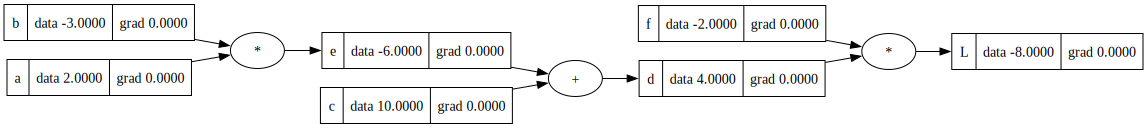

In [2]:

'''Understanding gradient basics. The micrograd is roughly modelled based on pytorch's 'grad' function.'''

class Value():
    def __init__(self, data, _children=(), _op= '', label=''):
        self.data= data
        self.grad=0.0
        self._backward=lambda:None
        self._prev= set(_children)
        self._op= _op
        self.label= label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other= other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+') 
        def _backward():
            self.grad += 1.0 *out.grad
            other.grad += 1.0 *out.grad
        out._backward=_backward
        return out
    
    def __neg__(self):  # -self
        return self*(-1)
    
    def __sub__(self,other ):   #self-other
        return self +(-other)
    
    def __mul__(self,other):
        other= other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data *out.grad
            other.grad += self.data *out.grad
        out._backward=_backward
        return out
    
    def __rmul__(self, other):  # other*self
        return self*other
    
    def __truediv__(self, other):   #self/other
        return self*other**-1
    
    ''' we can use __pow__() to divide too : a/b = a*(1/b) = a*(b**-1)
     we have to redefine division above in the method __truediv__(): 
     we will also implement __pow__() function. we do this for powers other than Value objects viz: ints and floats.
     refer video: https://youtu.be/VMj-3S1tku0?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=5596'''
    def __pow__(self, other):  #self**other (other is a number and not a Value obj)
        assert isinstance(other,(int,float)), 'only supporting int/float powers for now '
        out= Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            # d(x**n)/dx= n(x**(n-1))
            self.grad += (other * self.data**(other -1))* out.grad
        out._backward= _backward
        return out

        

    def tanh(self):
        x= self.data
        t= (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out= Value(t, (self,), 'tanh')
        def _backward():
            self.grad+=(1-t**2) *out.grad
        out._backward=_backward
        return out
    
    
    def exp(self):
        x= self.data
        out = Value(math.exp(x), (self, ) , 'exp')
        def _backward():
            self.grad += out.data * out.grad     #since e**x 's derivative is same i.e. e**x
        out._backward = _backward
        return out
    
    def backward(self):
        topo=[]
        visited= set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad= 1.0
        for node in reversed(topo):
            node._backward()
    


from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot= Digraph (format='svg', graph_attr={'rankdir': 'LR'})   # LR= left to right
    nodes, edges= trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label= '{%s | data %.4f | grad %.4f }'% (n.label, n.data, n.grad), shape= 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it 
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1,n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+ n2._op)
    return dot




a=Value(2.0, label='a')
b= Value(-3.0, label='b')
c= Value(10.0, label='c')
e= a*b; e.label='e'
d= e+c 
d.label='d'
f= Value(-2, label='f')
L= d*f; L.label='L'
draw_dot(L)

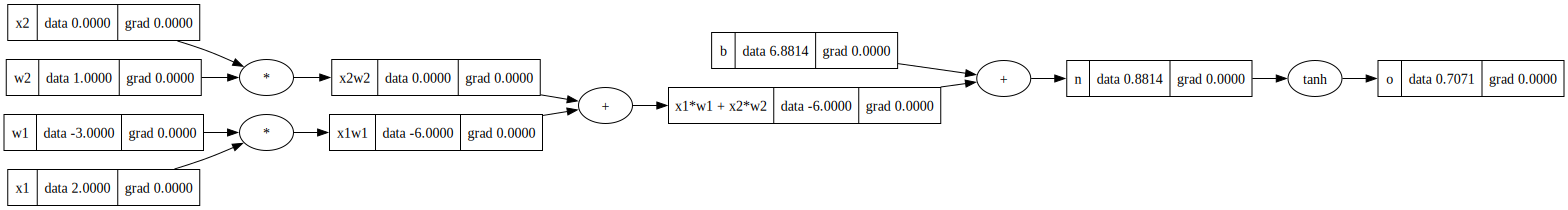

In [3]:
'''Second example with neuron'''

#inputs x1,x2
x1=Value(2.0, label='x1')
x2= Value(0.0, label='x2')
# weights w1,w2
w1= Value(-3, label='w1')
w2= Value(1.0, label='w2')
#bias of the neuron 
b= Value(6.8813735870195432, label='b')
#(x1*w1 +x2*w2 +b)
x1w1= x1*w1; x1w1.label='x1w1'
x2w2= x2*w2; x2w2.label='x2w2'
x1w1x2w2= x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n=x1w1x2w2+b; n.label='n'
o = n.tanh(); o.label='o'
draw_dot(o)

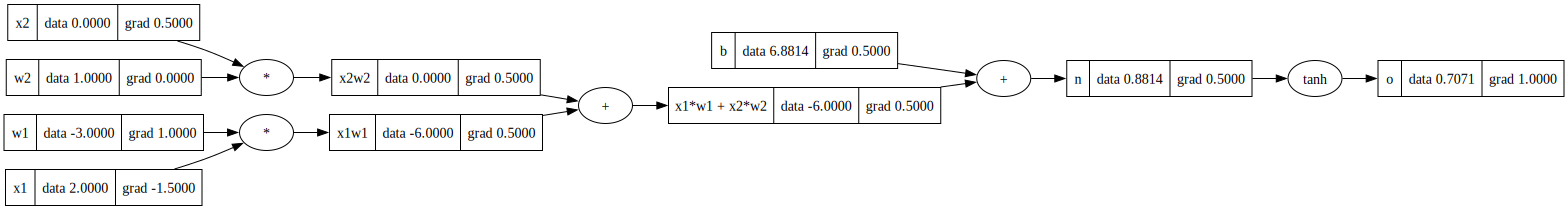

In [4]:
o.backward()
draw_dot(o)

In [5]:
# x1+1
# # above is possible because we added a line in Value class saying (other) can be value else it converts into Value object
# # same goes for x1*3.
# # but 3*x1 gives error. For this we used  dunder method __rmul__() in the Value class
# x1*3
# 3*x1 
# # above line is possible because of the __rmul__. it basically redirects 3*x1 as x1*3 which is then processed by the program
# a-b
# # we used __sub__ and __neg__ methods to process a-b

In [6]:
# # lets split tanh() for fun

# #inputs x1,x2
# x1=Value(2.0, label='x1')
# x2= Value(0.0, label='x2')
# # weights w1,w2
# w1= Value(-3, label='w1')
# w2= Value(1.0, label='w2')
# #bias of the neuron 
# b= Value(6.8813735870195432, label='b')
# #(x1*w1 +x2*w2 +b)
# x1w1= x1*w1; x1w1.label='x1w1'
# x2w2= x2*w2; x2w2.label='x2w2'
# x1w1x2w2= x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# n=x1w1x2w2+b; n.label='n'

# # o = n.tanh(); o.label='o'
# e= (2*n).exp()
# e.label='e'
# o= (e - 1) / (e + 1)
# o.label= 'o'
# o.backward()
# draw_dot(o)


<h1>Autograd is done. YaY!!!</h1>
<p>Now we practice same with pytorch and tensors.</p>

In [3]:
'''Micrograd is a scaler values engine i.e. we only have scaler values for Value.data.
PyTorch works with tensors which gives a lot more functionality and efficiency.'''


import torch
import random
x1 = torch.Tensor([2.0]).double()    ; x1.requires_grad =True       
x2 = torch.Tensor([0.0]).double()    ; x2.requires_grad =True
w1 = torch.Tensor([-3.0]).double()    ; w1.requires_grad =True
w2 = torch.Tensor([1.0]).double()    ; w2.requires_grad =True
b = torch.Tensor([6.88137358701954]).double()    ; b.requires_grad =True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)


print(o.data.item())
o.backward()
print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


<h3><u><b>some other common activation functions like tanh are : </b></u></h3>
<ol><li>identity <ul><li>--> f(x)= x (nothing changes),</li></ul></li>
<li>binary step <ul><li>--> f(x)= 0 for x < 0 , 1 for x=>0,</li></ul></li>
<li>logistic or sigmoid <ul><li>--> f(x)= 1 / (1-e**(-x)) = e**x / (e**x -1), (zero to one)</li></ul></li>
<li>tanh <ul><li>--> f(x)= [2 / (1+ e**(-2*x))] - 1 , (zero to one)</li></ul></li>
<li>arctan <ul><li>--> f(x)= tan**(-1)(x) , (tan inverse of x) : alternative to sigmoid or tanh </li></ul></li>
<li>relu (rectified linear unit) <ul><li>--> f(x)= 0 for x < 0, x for x=>0, </li></ul></li>
<li>leaky relu <ul><li>--> f(x) = 0.01*x for x < 0, x for x => 0,</li></ul></li>
<li>softmax (when handling probabilities/ categorical values)</li>
</ol>

In [8]:
# we cast all the tensors to double coz python by default assigns double to float values and we are using Value object .
# normal tensors will be having dtypes as float32, using double we have float64
x1.dtype

torch.float64

In [9]:
# lets make a neural network now :


class Neuron:
    def __init__(self, nin):    #nin = no of inputs to the neuron
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]  # weights of all inputs
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # sigma(w*x) + b
        act= sum((wi*xi for wi,xi in zip(self.w, x)), self.b)    #activation function of the neuron
        out= act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:    # is a list of neurons; nout is how many neurons we want
    def __init__(self, nin, nout):
        self.neurons= [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps= neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:      #Multi-Layer-Perceptron is a combination of layers which is representative of our neural network architechture
    def __init__(self, nin, nouts):     # nouts is a list of nouts (Layer) so we create a layer for every nout given to MLP
        sz= [nin] + nouts
        self.layers= [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]







In [10]:
x = [2.0,3.0]
n = Neuron(2)       # here 2 is nin(no of inputs)... ideally is equal to len(x)
n(x)         # this is handled by __call__() function
# above two lines is how to create neuron


Value(data=-0.9892438360623619)

In [ ]:
# lets create a layer of neurons now

l= Layer(2,3)
l(x)
# the following output contains the outputs of the 3 neurons we created in the layer
# each of the layer has 2 inputs (list x) and two weights (random.uniform)

[Value(data=0.8970910118364546),
 Value(data=-0.9907466020973811),
 Value(data=-0.4959288162530057)]

In [11]:
x=[2.0, 3.0, 1.0]       # 3 dimensional input
m= MLP(3, [4,4,1])      # 3 input neurons(len(x)), two layers of 4 neurons and 1 layer of 1 neurons (output layer)
m(x)


Value(data=-0.9800261466859337)

In [ ]:
draw_dot(m(x))

In [13]:
# example application of the nn
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]     # desired targets.. ie. for input xs[0], target is ys[0] and so on


In [14]:
ypred= [m(x) for x in xs]
ypred

[Value(data=-0.9889508772559502),
 Value(data=-0.9871668814413103),
 Value(data=-0.884761278851223),
 Value(data=-0.9882916318928068)]

<h1><u>Types of Loss Functions:</u></h1>
<ul>
    <li>MSE</li>
    <li>SE</li>
    <li>max-margin loss aka Hinge loss (for binary classification problems)</li>
    <li>binary cross-entropy loss (for binary classification problems)</li>
    
</ul>
<p>And many more...</p>

In [15]:
# we define a single number to see how well the nn is performing. lets call it a loss or loss function
# we will implement SE(squared error) loss
# [(yout-ygt)**2 for ygt, yout in zip(ys, ypred)]
loss=sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))
# we want to minimize this loss. 0 is perfect score(and nearly impossible)
loss


Value(data=7.922673857376122)

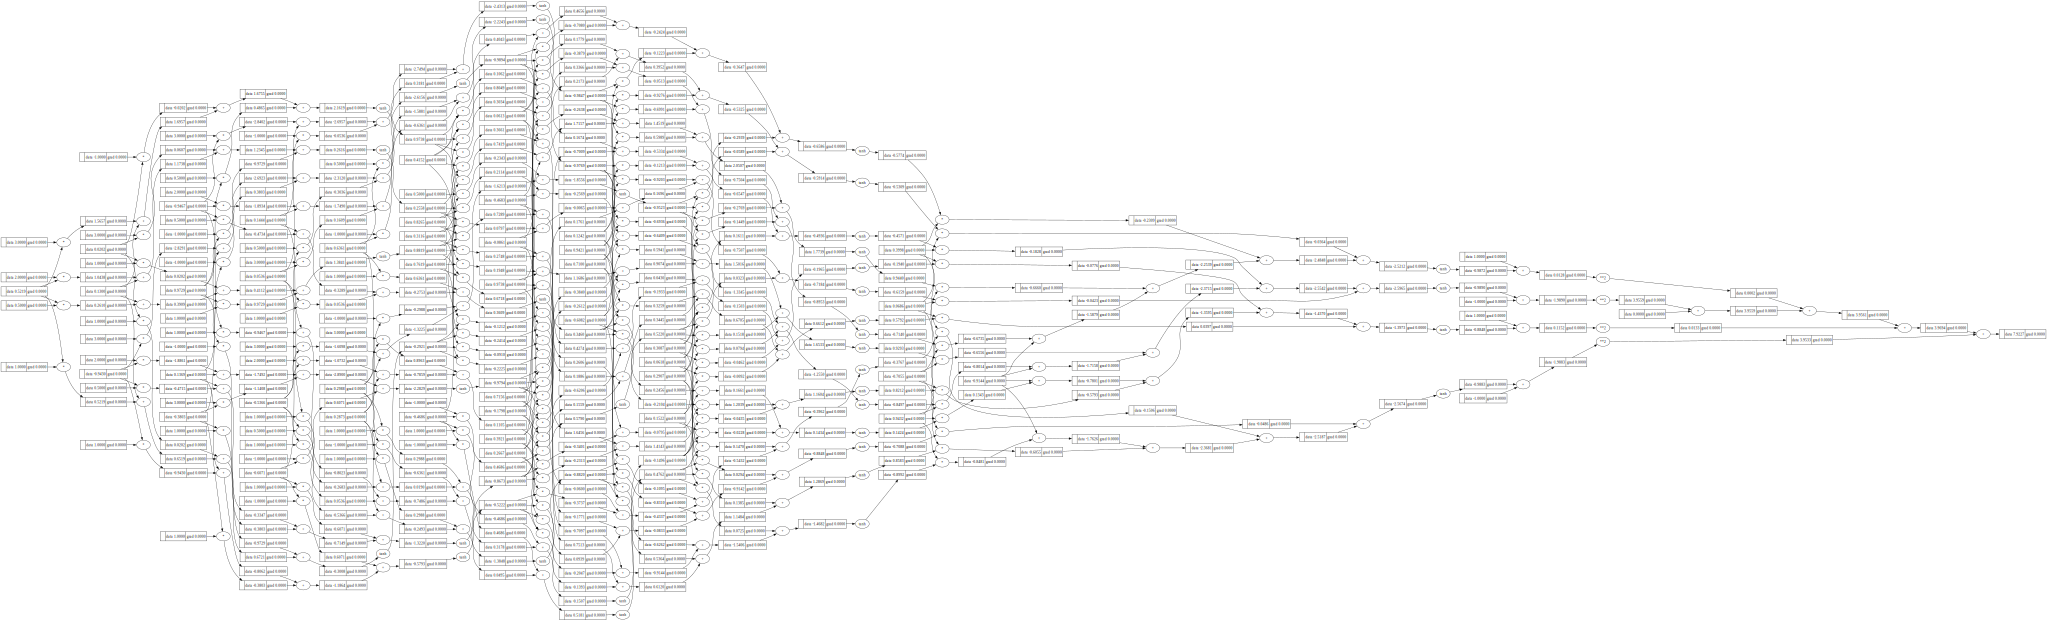

In [16]:
# print('foo')
draw_dot(loss)

In [17]:
m.parameters()

[Value(data=0.5219136308065264),
 Value(data=0.02022798065343978),
 Value(data=0.9729197692121565),
 Value(data=0.12996754945283828),
 Value(data=-0.943044697610109),
 Value(data=-0.3802577826644693),
 Value(data=-0.6071032672116281),
 Value(data=0.1368543455476421),
 Value(data=-0.9467239088282255),
 Value(data=0.05362914815065811),
 Value(data=0.6361438851854582),
 Value(data=0.14444753663864862),
 Value(data=-0.5366144345053132),
 Value(data=0.2987822727902518),
 Value(data=-0.4685598416960244),
 Value(data=0.28734641325199695),
 Value(data=0.8264966726887466),
 Value(data=0.39208859947286734),
 Value(data=0.7099728335474524),
 Value(data=0.15219066988340124),
 Value(data=-0.4682896570098163),
 Value(data=0.7618513067657453),
 Value(data=0.26666915799333957),
 Value(data=-0.6081951193038473),
 Value(data=0.2907445748506787),
 Value(data=0.9737578497581894),
 Value(data=0.4151552702164427),
 Value(data=0.715586548536721),
 Value(data=0.12416372264646403),
 Value(data=0.30868385227032

In [18]:
m.layers[0].neurons[0].w[0].grad
m.layers[0].neurons[0].w[0].data

0.5219136308065264

In [19]:
loss.backward()


In [20]:
for p in m.parameters():
    p.data += -0.01 * p.grad

In [21]:
m.layers[0].neurons[0].w[0].data
#we see that the value is slightly changed in such a way that loss is decreased?

0.5224774887594898

In [22]:
ypred= [m(x) for x in xs]
loss=sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))
loss
# loss after second pass is slightly better loss than the previous loss in the first forward pass

Value(data=7.9215020084991625)

In [23]:
# we see here that loss function is almost zero after many passes. and the predicted values are 
# almost same as the target values
ypred

[Value(data=-0.9888003499233966),
 Value(data=-0.9870423149433343),
 Value(data=-0.8847607341877629),
 Value(data=-0.9881466713139567)]

In [24]:
# the parameters ie. weights and biases for our nn model are as follows]
m.parameters()

[Value(data=0.5224774887594898),
 Value(data=0.0209853187144279),
 Value(data=0.9724633743941206),
 Value(data=0.13025396108596518),
 Value(data=-0.9428835205450183),
 Value(data=-0.38012111897393613),
 Value(data=-0.6073598001267891),
 Value(data=0.13696983427049858),
 Value(data=-0.946828681948969),
 Value(data=0.05334234839175668),
 Value(data=0.6356752743315921),
 Value(data=0.1441346555827523),
 Value(data=-0.5364614370996095),
 Value(data=0.29895914163035503),
 Value(data=-0.46878521838401904),
 Value(data=0.2873803866198779),
 Value(data=0.826095615055987),
 Value(data=0.39218099933229805),
 Value(data=0.7094444358088655),
 Value(data=0.1524619922066955),
 Value(data=-0.4683589092256046),
 Value(data=0.7619819379682063),
 Value(data=0.26674108609882763),
 Value(data=-0.6079219753940684),
 Value(data=0.2906010932025732),
 Value(data=0.9736172927428043),
 Value(data=0.4149616598439439),
 Value(data=0.7153186510586524),
 Value(data=0.12354852365166445),
 Value(data=0.30900991764227

In [25]:
# now automating the forward pass and backward pass

for k in range(20):
    

    # forward pass
    ypred= [m(x) for x in xs]
    loss= sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))

    # backward pass
    for p in m.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in m.parameters():
        p.data += -0.1 * p.grad
    print(k, loss.data)

0 7.9215020084991625
1 7.908782745318159
2 7.892186999170798
3 7.869466561716582
4 7.836431430457374
5 7.784375216435798
6 7.692345666972344
7 7.497885119166016
8 6.940976850801644
9 4.424327135362995
10 3.456251322429759
11 3.1101539632948763
12 1.2968231116639468
13 0.09511931469888514
14 0.05709224340144459
15 0.04443841027127511
16 0.0373174925958705
17 0.03253004148219013
18 0.028995906395978814
19 0.02623431262125419


In [26]:
ypred

[Value(data=0.9052612012914137),
 Value(data=-0.9151059609970811),
 Value(data=-0.9479191133565306),
 Value(data=0.9143293747617707)]